In [2]:
import numpy as np
import csv
import os
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
nteams = 20
nmatches = (nteams-1)*2

Data Pre-processing

In [4]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [5]:
def season_game_mat(season_dir, team_map):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    
    for entry in os.scandir(season_dir):
        if '/1-' in entry.path:
            csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        next(reader)
        for row in reader:
            team1 = team_map[row[1]]
            team2 = team_map[row[2]]

            score = row[3].split('-')

            # 1 for win, 0 for draw, -1 for loss

            if(int(score[0]) > int(score[1])):
                game_mat[team1, team_index[team1]] = 1
                game_mat[team2, team_index[team2]] = -1
            elif(int(score[0]) < int(score[1])):
                game_mat[team1, team_index[team1]] = -1
                game_mat[team2, team_index[team2]] = 1

            team_index[team1] += 1
            team_index[team2] += 1
    
    return game_mat

In [6]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
    for entry in os.scandir(cdir):
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1

In [7]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [28]:
def disc_error(outputs, targets):
    rounded_outputs = np.round(outputs)
    err = 0
    n = 0
    for i in range(len(outputs)):
        if(int(rounded_outputs[i]) != int(targets[i])):
            err += 1
        n += 1
    return float(err)/n

In [12]:
ntraining = 45
ntesting = nseasons - ntraining

training_game_mats = np.reshape(game_mats[:ntraining], (-1, nmatches))
testing_game_mats = np.reshape(game_mats[ntraining:], (-1, nmatches))

In [13]:
X_trainings = []
Y_trainings = []
for i in range(1, nmatches):
    X_training = []
    Y_training = []
    for seq in training_game_mats:
        for j in range(nmatches-i):
            X_training.append(seq[j:j+i])
            Y_training.append(seq[j+i])
    
    X_trainings.append(X_training)
    Y_trainings.append(Y_training)

In [34]:
X_testings = []
Y_testings = []
for i in range(1, nmatches):
    X_testing = []
    Y_testing = []
    for seq in testing_game_mats:
        for j in range(nmatches-i):
            X_testing.append(seq[j:j+i])
            Y_testing.append(seq[j+i])
            
    X_testings.append(X_testing)
    Y_testings.append(Y_testing)

In [17]:
layer_sizes = [30, 50, 100, 200]

In [18]:
nns = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    nns[key] = []

In [19]:
for i in range(nmatches-1):
    for size in layer_sizes:
        key = str(size)+'_neuron_layers'       
        nn = MLPRegressor(hidden_layer_sizes=(size,2), solver='lbfgs')
        nn.fit(X_trainings[i], Y_trainings[i])
        nns[key].append(nn)

ValueError: Expected 2D array, got 1D array instead:
array=[ array([-1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1, -1,  1,  1,  0,  0,  0,
       -1, -1,  1,  1, -1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
       -1,  1,  1])
 array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  0,  1,  1,  0,  1,  0, -1,
        1,  1, -1,  1,  1,  1,  1,  1, -1,  0, -1,  1, -1, -1,  1, -1,  1,
        1,  1,  0])
 array([ 1, -1,  1,  1, -1,  1,  1,  0,  0,  1,  1, -1, -1,  0, -1,  0,  1,
        1,  1,  0,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1, -1,  1, -1,  1,
        0,  1,  0])
 ...,
 array([-1, -1, -1,  0, -1,  1,  0, -1,  0, -1, -1,  1, -1, -1, -1,  0, -1,
        1, -1, -1,  0,  0,  0,  1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  1,
       -1,  1,  1])
 array([-1,  0,  0, -1,  0, -1, -1, -1,  1,  1,  0, -1,  0,  0, -1, -1,  1,
       -1,  0,  0,  0, -1,  1, -1, -1,  0,  0, -1,  1, -1, -1,  0,  0, -1,
       -1,  0, -1])
 array([-1,  1,  1,  0,  0, -1, -1, -1, -1,  0,  1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1,  1,  0, -1,  1, -1,  0, -1,  1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [23]:
len(nns['100_neuron_layers'])

36

In [32]:
def score(key):
    training_accs = []
    training_errs = []

    with open('nn_1t_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("training")
        for i in range(nmatches-2):
            print(i)
            outputs = nns[key][i].predict(X_trainings[i])
            acc = 1 - disc_error(outputs, np.array(Y_trainings[i]))
            eerr = eucl_error(outputs, np.array(Y_trainings[i]))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('nn_1t_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("testing")
        for i in range(nmatches-2):
            print(i)
            outputs = nns[key][i].predict(X_testings[i])
            acc = 1 - disc_error(outputs, np.array(Y_testings[i]))
            eerr = eucl_error(outputs, np.array(Y_testings[i]))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [25]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

In [35]:
for size in layer_sizes:
    print(size)
    key = str(size)+'_neuron_layers'
    score(key)

30
training
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
testing
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
50
training
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
testing
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
100
training
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
testing
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
200
training
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
testing
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [39]:
def plot(y, ylabel, title, imname):
    x = range(1,nmatches-1)
    yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
    r2 = np.round(r2_score(y, yfit),decimals=2)
    mean = np.round(np.mean(y), decimals=2)

    plt.scatter(x, y, s = 5)
    plt.plot(x, yfit)
    plt.axis([0,nmatches,0,1])
    plt.text(1, 0.95, 'R^2: ' + str(r2))
    plt.text(1, 0.85, 'Mean: ' + str(mean))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('nn1tplots/' + imname + '.png')
    plt.show()

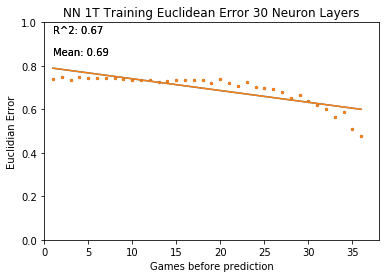

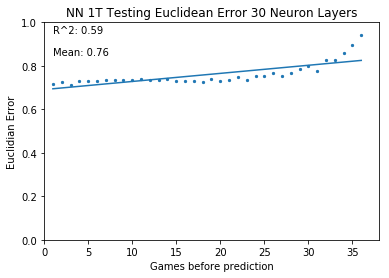

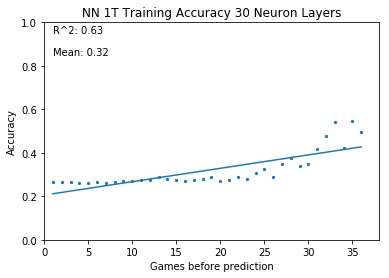

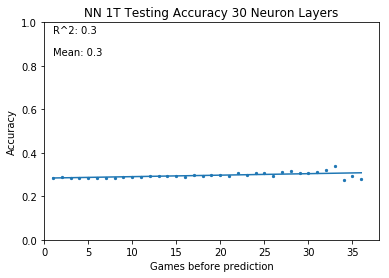

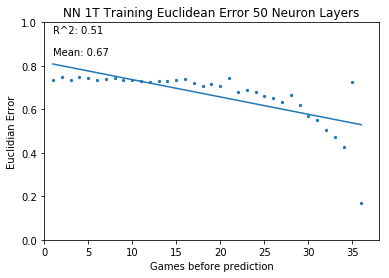

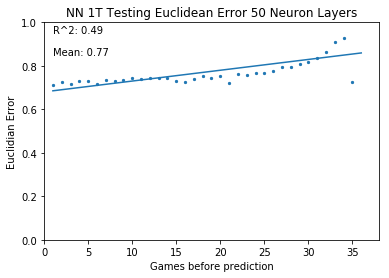

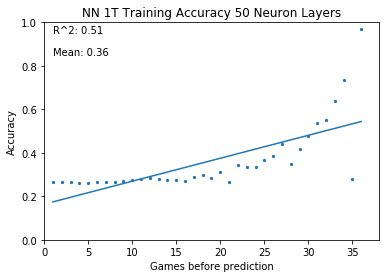

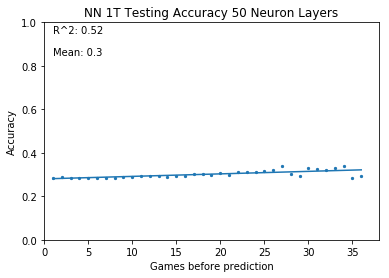

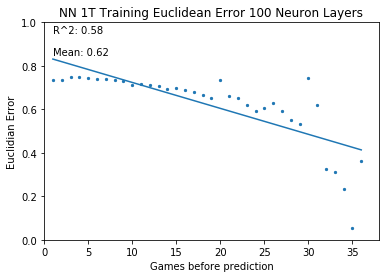

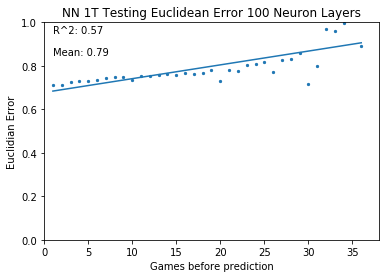

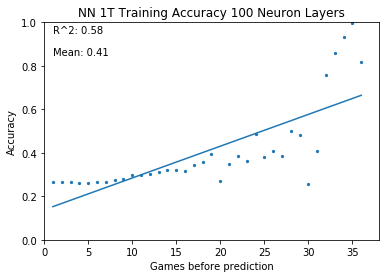

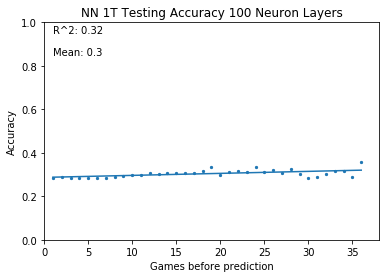

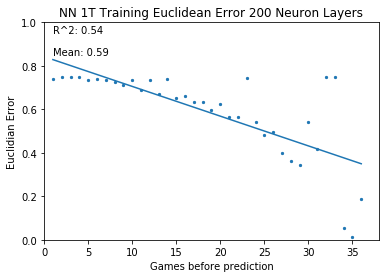

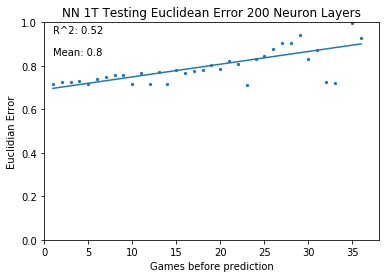

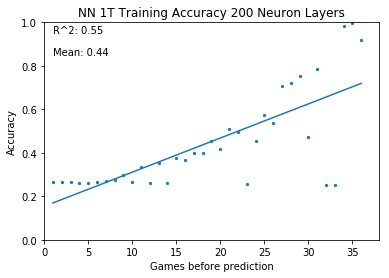

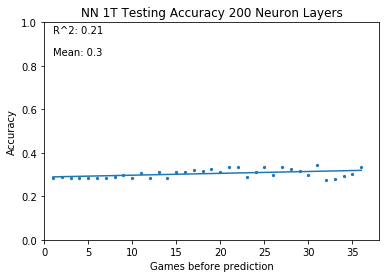

In [41]:
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    title = ' ' + str(size) + ' Neuron Layers'
    plot(training_errs_dict[key], 'Euclidian Error', 'NN 1T Training Euclidean Error' + title, 'nn_training_error_plot_'+key)
    plot(testing_errs_dict[key], 'Euclidian Error', 'NN 1T Testing Euclidean Error' + title, 'nn_testing_error_plot_'+key)
    plot(training_accs_dict[key], 'Accuracy', 'NN 1T Training Accuracy' + title, 'nn_training_accuracy_plot_'+key)
    plot(testing_accs_dict[key], 'Accuracy', 'NN 1T Testing Accuracy' + title, 'nn_testing_accuracy_plot_'+key)

In [27]:
nns['100_neuron_layers'][0].predict(X_trainings[0])

array([  6.00600601e-05,   6.00600601e-05,   6.00600601e-05, ...,
         6.00600601e-05,   6.00600601e-05,   6.00600601e-05])